In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
def filter_swap_pairs(df_filepaths: str, token_0: str, token_0_decimal: int, token_1: str, token_1_decimal: int) -> pl.DataFrame:
    '''
    Filter data for a specific swap pair of tokens
    '''

    # scan for token 0 -> token 1 swap
    q_in = (
        pl.scan_parquet(df_filepaths)
        .filter((pl.col("tokenIn_symbol") == token_0) & (pl.col("tokenOut_symbol") == token_1))
    )

    # convert query into df
    df_in = q_in.collect()

    # apply decimal converesion
    df_in = df_in.with_columns(
        amountIn= pl.col("amountIn") / 10 ** token_0_decimal,
        amountOut= pl.col("amountOut") / 10 ** token_1_decimal
    )

    # calculate execution price
    df_in = df_in.with_columns(
        executionPrice= pl.col("amountOut") / pl.col("amountIn")
    )

    # scan for token 1 -> token 0 swap
    q_out = (
        pl.scan_parquet(df_filepaths)
        .filter((pl.col("tokenIn_symbol") == token_1) & (pl.col("tokenOut_symbol") == token_0))
    )

    # convert query into df
    df_out = q_out.collect()
    
    # apply decimal converesion
    df_out = df_out.with_columns(
        amountIn= pl.col("amountIn") / 10 ** token_1_decimal,
        amountOut= pl.col("amountOut") / 10 ** token_0_decimal
    )

    # calculate execution price
    df_out = df_out.with_columns(
        executionPrice= pl.col("amountIn") / pl.col("amountOut")
    )

    # concat dfs
    return pl.concat([df_in, df_out])

In [4]:
swap_df_usdc = filter_swap_pairs(df_filepaths, 'WETH', 18, 'USDC', 6)
swap_df_usdt = filter_swap_pairs(df_filepaths, 'WETH', 18, 'USDT', 6)
# binance has pegged tokens and they both have 18 decimals
swap_df_eth = filter_swap_pairs(df_filepaths, 'ETH', 18, 'USDC', 18)

In [5]:
swap_df = pl.concat([swap_df_usdc, swap_df_usdt, swap_df_eth])

In [6]:
swap_df.shape

(6689345, 14)

In [7]:
# filter out outlier values that are too large or too small. We get weird values probably due precision rounding errors because values are stored as float64s
filter_swap_df = swap_df.filter((pl.col("executionPrice") < 2500) & (pl.col("executionPrice") > 1000))

# second filter for transactions larger than $1 USD
filter_swap_df = filter_swap_df.filter((pl.col("amountInUSD") > 1) & (pl.col("amountOutUSD") > 1))

In [8]:
filter_swap_df.shape

(6431715, 14)

### Standardize Price Format

In [9]:
chain_price_df = pl.read_parquet('data/price/*.parquet')
chain_price_df = chain_price_df.to_pandas()

In [10]:
swap_df_pandas = filter_swap_df.to_pandas()

# change column name from executionPrice to price
dex_price_df = swap_df_pandas[['timestamp', 'executionPrice', 'blockchain']].rename(columns={'executionPrice': 'price'})

# apply smoothing to the data grouped by blockchain
dex_price_df['price'] = dex_price_df.groupby('blockchain')['price'].transform(lambda x: x.rolling(10, 1).mean())

In [11]:
first_timestamp_chain = chain_price_df['timestamp'].min()
last_timestamp_chain = chain_price_df['timestamp'].max()

In [12]:
# create empty dataframe with timestamp range in second frequency
price_index = pd.date_range(
    first_timestamp_chain,
    last_timestamp_chain,
    freq='1s'
)

In [13]:
# change price_index into a dataframe
price_index = pd.DataFrame(price_index, columns=['timestamp'])

In [14]:
# left merge chain_df with empty timestamps_df
price_oracle_chain_df = pd.merge(price_index, chain_price_df[['timestamp', 'price', 'blockchain']], on='timestamp', how='left')
# Forward-fill missing values
price_oracle_chain_df.fillna(method='ffill', inplace=True)
# sort by timestamp
price_oracle_chain_df = price_oracle_chain_df.sort_values('timestamp', ascending=True)

In [15]:
df_data = []

In [16]:
# TODO - optimize forward fill with polars instead of pandas?
# https://stackoverflow.com/questions/73917061/forward-filling-by-column-values-in-python-polars

# first get list of unique blockchain values
blockchain_list = dex_price_df['blockchain'].unique().tolist()

for blockchain in blockchain_list:
    # filter dex_price_df by blockchain
    filter_dex_price_df = dex_price_df[dex_price_df['blockchain'] == blockchain]
    # left merge chain_df with empty timestamps_df
    merged_df = pd.merge(price_index, filter_dex_price_df[['timestamp', 'price']], on='timestamp', how='left')
    # Forward-fill missing values
    merged_df.fillna(method='ffill', inplace=True)
    # calucate the mean values of duplicate entries
    merged_df = merged_df.groupby('timestamp').mean().reset_index()
    # sort by timestamp
    merged_df = merged_df.sort_values('timestamp', ascending=True)

    # add blockchain column
    merged_df['blockchain'] = blockchain
    df_data.append(merged_df)
    

In [17]:
for df in df_data:
    print(df.shape)

print(price_oracle_chain_df.shape)

(7770769, 3)
(7770769, 3)
(7770769, 3)
(7770769, 3)
(7770769, 3)
(7770769, 3)


In [18]:
# concat price_chain_oracle and all dfs in df_data
final_price_oracle_df = pd.concat([price_oracle_chain_df] + df_data)

In [19]:
final_price_oracle_df

,timestamp,price,blockchain
0,2023-03-01 05:22:47,1650.407264,chainlink
1,2023-03-01 05:22:48,1650.407264,chainlink
2,2023-03-01 05:22:49,1650.407264,chainlink
3,2023-03-01 05:22:50,1650.407264,chainlink
4,2023-03-01 05:22:51,1650.407264,chainlink
...,...,...,...
7770764,2023-05-30 03:55:31,1903.205341,bsc
7770765,2023-05-30 03:55:32,1903.205341,bsc
7770766,2023-05-30 03:55:33,1903.205341,bsc
7770767,2023-05-30 03:55:34,1903.205341,bsc


In [20]:
# for value in df_data, remove value
del df_data

### Plotting

In [21]:
# reset index
plot_df = final_price_oracle_df.reset_index()

In [22]:
# pivot blockchain column to column headers. Make token the index
pivot_df = plot_df.pivot(index='timestamp', columns='blockchain', values='price')

In [23]:
pivot_df

blockchain,arbitrum,bsc,chainlink,ethereum,optimism,polygon
timestamp,,,,,,
2023-03-01 05:22:47,NaN,NaN,1650.407264,1651.642600,NaN,NaN
2023-03-01 05:22:48,NaN,NaN,1650.407264,1652.939547,NaN,NaN
2023-03-01 05:22:49,NaN,NaN,1650.407264,1652.939547,NaN,NaN
2023-03-01 05:22:50,NaN,NaN,1650.407264,1652.939547,NaN,NaN
2023-03-01 05:22:51,NaN,NaN,1650.407264,1652.939547,NaN,NaN
...,...,...,...,...,...,...
2023-05-30 03:55:31,1902.468522,1903.205341,1909.117200,1903.696286,1904.358345,1904.330730
2023-05-30 03:55:32,1902.468522,1903.205341,1909.117200,1903.696286,1904.358345,1902.312289
2023-05-30 03:55:33,1902.468522,1903.205341,1909.117200,1903.696286,1904.358345,1902.312289


In [24]:
# copy pivot df
price_deviation_df = pivot_df.copy(deep=True)

In [25]:
# add columns for price deviation
price_deviation_df['arbitrum'] = (price_deviation_df['arbitrum'] - price_deviation_df['chainlink']) / 100
price_deviation_df['bsc'] = (price_deviation_df['bsc'] - price_deviation_df['chainlink']) / 100
price_deviation_df['ethereum'] = (price_deviation_df['ethereum'] - price_deviation_df['chainlink']) / 100
price_deviation_df['optimism'] = (price_deviation_df['optimism'] - price_deviation_df['chainlink']) / 100
price_deviation_df['polygon'] = (price_deviation_df['polygon'] - price_deviation_df['chainlink']) / 100

In [26]:
price_deviation_df

blockchain,arbitrum,bsc,chainlink,ethereum,optimism,polygon
timestamp,,,,,,
2023-03-01 05:22:47,NaN,NaN,1650.407264,0.012353,NaN,NaN
2023-03-01 05:22:48,NaN,NaN,1650.407264,0.025323,NaN,NaN
2023-03-01 05:22:49,NaN,NaN,1650.407264,0.025323,NaN,NaN
2023-03-01 05:22:50,NaN,NaN,1650.407264,0.025323,NaN,NaN
2023-03-01 05:22:51,NaN,NaN,1650.407264,0.025323,NaN,NaN
...,...,...,...,...,...,...
2023-05-30 03:55:31,-0.066487,-0.059119,1909.117200,-0.054209,-0.047589,-0.047865
2023-05-30 03:55:32,-0.066487,-0.059119,1909.117200,-0.054209,-0.047589,-0.068049
2023-05-30 03:55:33,-0.066487,-0.059119,1909.117200,-0.054209,-0.047589,-0.068049


In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

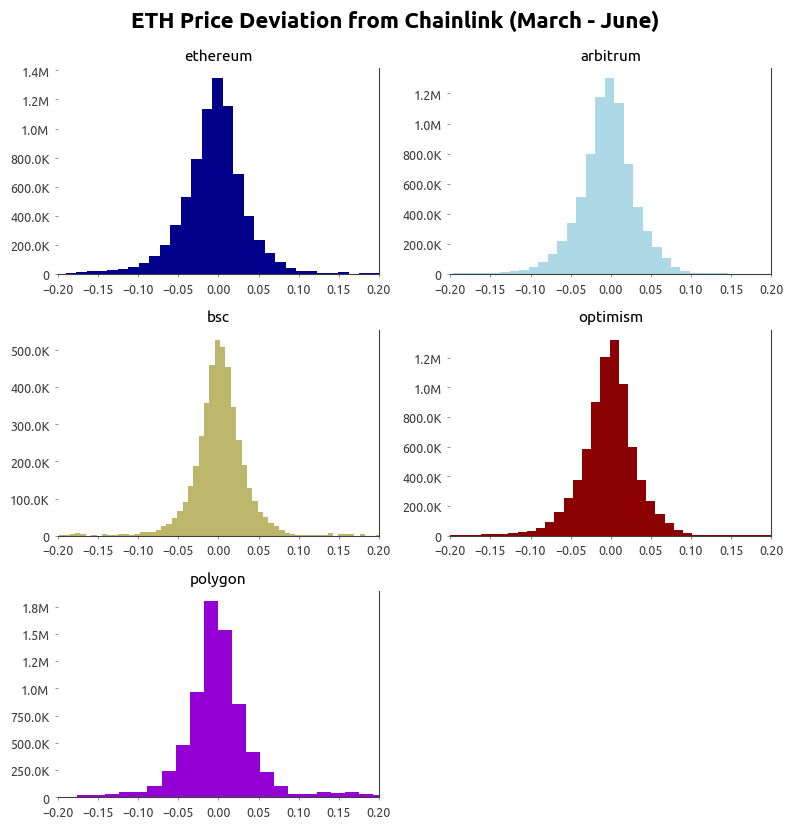

In [50]:
import matplotlib.pyplot as plt

def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'{value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return f'{value:.0f}'
    

# Create a figure and an array of subplots
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

# Define the data and labels for each histogram
data = {
    'ethereum': price_deviation_df['ethereum'],
    'arbitrum': price_deviation_df['arbitrum'],
    'bsc': price_deviation_df['bsc'],
    'optimism': price_deviation_df['optimism'],
    'polygon': price_deviation_df['polygon']
}

labels = ['ethereum', 'arbitrum', 'bsc', 'optimism', 'polygon']
colors = ['darkblue', 'lightblue', 'darkkhaki', 'darkred', 'darkviolet']


# Iterate over the subplots and create histograms
for i, ax in enumerate(axs.flat):
    if i < len(labels):
        ax.hist(data[labels[i]], bins=250, color=colors[i].format(i))
        ax.set_title(labels[i])

        # Set common x and y axis limits
        ax.set_xlim(-0.2, 0.2)
        
        # set y axis formatter
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

    else:
        # Remove empty subplot
        fig.delaxes(ax)

# Adjust the spacing between subplots
plt.tight_layout()

# Add a main title
fig.suptitle('ETH Price Deviation from Chainlink (March - June)', fontsize=16, fontweight='bold', y=1.03)

# Show the plot
plt.show()

# save picture
fig.savefig('charts/eth_price_deviation.png', dpi=300, bbox_inches='tight')